# SVG 工具提示

此示例展示了如何创建一个当鼠标悬停在 matplotlib 图形上时显示的工具提示。

虽然可以使用 CSS 或 JavaScript 创建工具提示，但在这里我们使用 matplotlib 创建它，并在鼠标悬停在图形上时切换其可见性。这种方法提供了对工具提示位置和外观的完全控制，但需要更多的代码来实现。

另一种方法是将工具提示内容放在 SVG 对象的 ``title`` 属性中。然后，使用现有的 js/CSS 库，在浏览器中创建工具提示相对简单。工具提示的内容由 ``title`` 属性决定，外观由 CSS 决定。

作者： David Huard

In [ ]:
from pathlib import Path

Path(".temp").mkdir(parents=True, exist_ok=True)

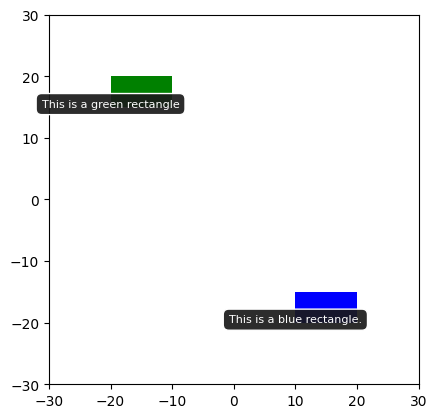

In [2]:
from io import BytesIO
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

ET.register_namespace("", "http://www.w3.org/2000/svg")

fig, ax = plt.subplots()

# Create patches to which tooltips will be assigned.
rect1 = plt.Rectangle((10, -20), 10, 5, fc='blue')
rect2 = plt.Rectangle((-20, 15), 10, 5, fc='green')

shapes = [rect1, rect2]
labels = ['This is a blue rectangle.', 'This is a green rectangle']

for i, (item, label) in enumerate(zip(shapes, labels)):
    patch = ax.add_patch(item)
    annotate = ax.annotate(labels[i], xy=item.get_xy(), xytext=(0, 0),
                           textcoords='offset points', color='w', ha='center',
                           fontsize=8, bbox=dict(boxstyle='round, pad=.5',
                                                 fc=(.1, .1, .1, .92),
                                                 ec=(1., 1., 1.), lw=1,
                                                 zorder=1))

    ax.add_patch(patch)
    patch.set_gid(f'mypatch_{i:03d}')
    annotate.set_gid(f'mytooltip_{i:03d}')

# Save the figure in a fake file object
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_aspect('equal')

f = BytesIO()
plt.savefig(f, format="svg")

# --- Add interactivity ---

# Create XML tree from the SVG file.
tree, xmlid = ET.XMLID(f.getvalue())
tree.set('onload', 'init(event)')

for i in shapes:
    # Get the index of the shape
    index = shapes.index(i)
    # Hide the tooltips
    tooltip = xmlid[f'mytooltip_{index:03d}']
    tooltip.set('visibility', 'hidden')
    # Assign onmouseover and onmouseout callbacks to patches.
    mypatch = xmlid[f'mypatch_{index:03d}']
    mypatch.set('onmouseover', "ShowTooltip(this)")
    mypatch.set('onmouseout', "HideTooltip(this)")

# This is the script defining the ShowTooltip and HideTooltip functions.
script = """
    <script type="text/ecmascript">
    <![CDATA[

    function init(event) {
        if ( window.svgDocument == null ) {
            svgDocument = event.target.ownerDocument;
            }
        }

    function ShowTooltip(obj) {
        var cur = obj.id.split("_")[1];
        var tip = svgDocument.getElementById('mytooltip_' + cur);
        tip.setAttribute('visibility', "visible")
        }

    function HideTooltip(obj) {
        var cur = obj.id.split("_")[1];
        var tip = svgDocument.getElementById('mytooltip_' + cur);
        tip.setAttribute('visibility', "hidden")
        }

    ]]>
    </script>
    """

# Insert the script at the top of the file and save it.
tree.insert(0, ET.XML(script))
ET.ElementTree(tree).write('.temp/svg_tooltip.svg')